# General Setup
This file contains our experiment setup and evaluation.  

The two experiments are set up in a way that they can be run individually. All necessary imports are listed in the cell below.

In [2]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# to make results reproducible
seed = 42

# Experiment 1: In Distribution 

Here we use the Reasoning Pattern Dataset `reasoning_patterns_dataset.csv` for both training and testing of the probe. 

In [3]:
# ------------------------
# 1. Load dataset
# ------------------------
df = pd.read_csv("reasoning_patterns_dataset.csv")
texts = df["text_input"].tolist()
labels = df["reasoning_class"].astype("category").cat.codes.tolist()  
# classes: 0=MP, 1=MT, 2=AC, 3=DA

In [4]:
# ------------------------
# 2. BoW baseline with TF-IDF
# ------------------------
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))  # unigrams + bigrams
X_bow = vectorizer.fit_transform(texts)

X_train, X_test, y_train, y_test = train_test_split(
    X_bow, labels, test_size=0.2, random_state=42, stratify=labels
)

clf_bow = LogisticRegression(max_iter=2000)
clf_bow.fit(X_train, y_train)
bow_acc = accuracy_score(y_test, clf_bow.predict(X_test))
print(f"BoW baseline accuracy: {bow_acc:.3f}")

BoW baseline accuracy: 0.468


In [5]:
# ------------------------
# 3. Load BERT
# ------------------------
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased", output_hidden_states=True).to(device)
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [6]:
# ------------------------
# 4. Encode texts & extract CLS embeddings per layer
# ------------------------
def get_cls_embeddings(texts, batch_size=16):
    all_layers = [[] for _ in range(13)]  # 0 = embedding layer, 1-12 = hidden layers
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            enc = tokenizer(batch, return_tensors="pt", padding=True, truncation=True).to(device)
            outputs = model(**enc)
            hidden_states = outputs.hidden_states

            for layer_i, layer_hidden in enumerate(hidden_states):
                cls_vecs = layer_hidden[:, 0, :].cpu().numpy()
                all_layers[layer_i].extend(cls_vecs)

    return [torch.tensor(layer) for layer in all_layers]

all_layer_embeddings = get_cls_embeddings(texts)

/tmp/ipykernel_27097/536125447.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return [torch.tensor(layer) for layer in all_layers]


In [7]:
# ------------------------
# 5. Train probes on BERT embeddings
# ------------------------
results = []
results_shuffled = []

for layer_i, X in enumerate(all_layer_embeddings):
    X_train, X_test, y_train, y_test = train_test_split(
        X.numpy(), labels, test_size=0.2, random_state=seed, stratify=labels
    )
    clf = LogisticRegression(max_iter=2000, random_state=seed)
    clf.fit(X_train, y_train)
    acc = accuracy_score(y_test, clf.predict(X_test))
    results.append(acc)
    print(f"BERT Layer {layer_i} with normal labels: {acc:.3f}")


    # Logistic regression with shuffled labels
    y_train_shuffled = np.random.permutation(y_train)  # shuffle training labels only
    clf_shuf = LogisticRegression(max_iter=2000, random_state=seed)
    clf_shuf.fit(X_train, y_train_shuffled)
    acc_shuf = accuracy_score(y_test, clf_shuf.predict(X_test))
    results_shuffled.append(acc_shuf)
    print(f"Accuracy BERT Layer {layer_i} with shuffled labels: {acc_shuf:.3f}")

BERT Layer 0 with normal labels: 0.250
Accuracy BERT Layer 0 with shuffled labels: 0.250
BERT Layer 1 with normal labels: 0.495
Accuracy BERT Layer 1 with shuffled labels: 0.245
BERT Layer 2 with normal labels: 0.492
Accuracy BERT Layer 2 with shuffled labels: 0.265
BERT Layer 3 with normal labels: 0.710
Accuracy BERT Layer 3 with shuffled labels: 0.228
BERT Layer 4 with normal labels: 0.828
Accuracy BERT Layer 4 with shuffled labels: 0.203
BERT Layer 5 with normal labels: 0.895
Accuracy BERT Layer 5 with shuffled labels: 0.263
BERT Layer 6 with normal labels: 0.917
Accuracy BERT Layer 6 with shuffled labels: 0.245
BERT Layer 7 with normal labels: 0.963
Accuracy BERT Layer 7 with shuffled labels: 0.205
BERT Layer 8 with normal labels: 0.968
Accuracy BERT Layer 8 with shuffled labels: 0.247
BERT Layer 9 with normal labels: 0.968
Accuracy BERT Layer 9 with shuffled labels: 0.300
BERT Layer 10 with normal labels: 0.980
Accuracy BERT Layer 10 with shuffled labels: 0.235
BERT Layer 11 with 

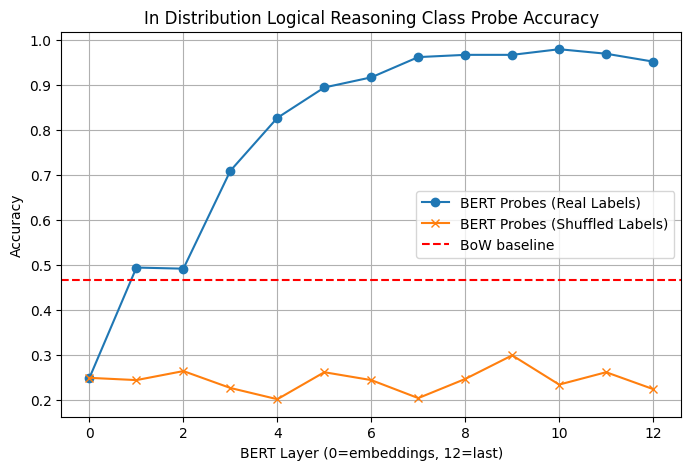

In [10]:
# ------------------------
# 6. Plot results
# ------------------------
plt.figure(figsize=(8, 5))
plt.plot(range(13), results, marker="o", label="BERT Probes (Real Labels)")
plt.plot(range(13), results_shuffled, marker="x", label="BERT Probes (Shuffled Labels)")
plt.axhline(y=bow_acc, color="r", linestyle="--", label="BoW baseline")
plt.xlabel("BERT Layer (0=embeddings, 12=last)")
plt.ylabel("Accuracy")
plt.title("In Distribution Logical Reasoning Class Probe Accuracy")
plt.legend()
plt.grid(True)
plt.savefig('accuracy_in_distribution.pdf')
plt.show()


# Experiment 2: Out of Distribution Test Data

Here we use a different dataset for testing of the probe `reasoning_patterns_test_whenever.csv` but keep the training dataset the same as in Experiment 1. 

In [11]:
# ------------------------
# 1. Load train & test datasets
# ------------------------
df_train = pd.read_csv("reasoning_patterns_dataset.csv")
df_test = pd.read_csv("reasoning_patterns_test_whenever.csv")

train_texts = df_train["text_input"].tolist()
train_labels = df_train["reasoning_class"].astype("category").cat.codes.tolist()

test_texts = df_test["text_input"].tolist()
test_labels = df_test["reasoning_class"].astype("category").cat.codes.tolist()

In [12]:
# ------------------------
# 2. Load BERT
# ------------------------
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased", output_hidden_states=True).to(device)
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [13]:
# ------------------------
# 3. Encode texts & extract CLS per layer
# ------------------------
def get_cls_embeddings(texts, batch_size=16):
    all_layers = [[] for _ in range(13)]  # 0 = embedding layer, 1-12 = hidden layers
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            enc = tokenizer(batch, return_tensors="pt", padding=True, truncation=True).to(device)
            outputs = model(**enc)
            hidden_states = outputs.hidden_states  # tuple of (13, batch, seq_len, hidden_dim)

            for layer_i, layer_hidden in enumerate(hidden_states):
                cls_vecs = layer_hidden[:, 0, :].cpu().numpy()
                all_layers[layer_i].extend(cls_vecs)

    return [np.array(layer) for layer in all_layers]

train_embeddings = get_cls_embeddings(train_texts)
test_embeddings = get_cls_embeddings(test_texts)

In [15]:
# ------------------------
# 4. Train probes (real vs shuffled labels)
# ------------------------
results_real = []
results_shuffled = []

for layer_i in range(13):
    X_train, y_train = train_embeddings[layer_i], train_labels
    X_test, y_test = test_embeddings[layer_i], test_labels

    # Logistic regression with real labels
    clf_real = LogisticRegression(max_iter=2000, random_state=seed)
    clf_real.fit(X_train, y_train)
    acc_real = accuracy_score(y_test, clf_real.predict(X_test))
    results_real.append(acc_real)

    # Logistic regression with shuffled labels
    y_train_shuffled = np.random.permutation(y_train)  # shuffle training labels only
    clf_shuf = LogisticRegression(max_iter=2000, random_state=seed)
    clf_shuf.fit(X_train, y_train_shuffled)
    acc_shuf = accuracy_score(y_test, clf_shuf.predict(X_test))
    results_shuffled.append(acc_shuf)

    print(f"Layer {layer_i}: Real={acc_real:.3f}, Shuffled={acc_shuf:.3f}")

Layer 0: Real=0.250, Shuffled=0.250
Layer 1: Real=0.388, Shuffled=0.343
Layer 2: Real=0.425, Shuffled=0.212
Layer 3: Real=0.287, Shuffled=0.231
Layer 4: Real=0.354, Shuffled=0.329
Layer 5: Real=0.700, Shuffled=0.232
Layer 6: Real=0.742, Shuffled=0.258
Layer 7: Real=0.578, Shuffled=0.246
Layer 8: Real=0.454, Shuffled=0.211
Layer 9: Real=0.264, Shuffled=0.244
Layer 10: Real=0.283, Shuffled=0.241
Layer 11: Real=0.250, Shuffled=0.279
Layer 12: Real=0.380, Shuffled=0.256


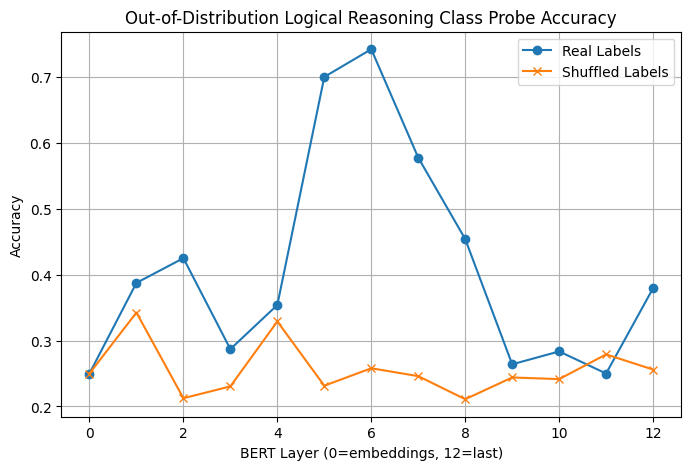

In [16]:
# ------------------------
# 5. Plot accuracy vs. layer
# ------------------------
plt.figure(figsize=(8, 5))
plt.plot(range(13), results_real, marker="o", label="Real Labels")
plt.plot(range(13), results_shuffled, marker="x", label="Shuffled Labels")
plt.xlabel("BERT Layer (0=embeddings, 12=last)")
plt.ylabel("Accuracy")
plt.title("Out-of-Distribution Logical Reasoning Class Probe Accuracy")
plt.legend()
plt.grid(True)
plt.savefig('accuracy_out_of_distribution.pdf')
plt.show()


### Out of Distribution - Sanity Check

Same code as Experiment 2 in section above but with train and test dataset from the `reasoning_patterns_dataset.csv`. We did this to make sure that when using the code from Experiment 2 but with the dataset of Experiment 1 the accuracy curves look like the ones from Experiment 1. This was done to make sure that the effect seen in Experiment 2 is not due to an error.

In [17]:
# ------------------------
# 1. Load train & test datasets
# ------------------------
# Load the dataset
df = pd.read_csv("reasoning_patterns_dataset.csv")

# Split into train and test sets (20% for testing)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df["reasoning_class"])

# Convert to lists for model input
train_texts = df_train["text_input"].tolist()
train_labels = df_train["reasoning_class"].astype("category").cat.codes.tolist()

test_texts = df_test["text_input"].tolist()
test_labels = df_test["reasoning_class"].astype("category").cat.codes.tolist()


In [18]:
# ------------------------
# 2. Load BERT
# ------------------------
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased", output_hidden_states=True).to(device)
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [19]:
# ------------------------
# 3. Encode texts & extract CLS per layer
# ------------------------
def get_cls_embeddings(texts, batch_size=16):
    all_layers = [[] for _ in range(13)]  # 0 = embedding layer, 1-12 = hidden layers
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            enc = tokenizer(batch, return_tensors="pt", padding=True, truncation=True).to(device)
            outputs = model(**enc)
            hidden_states = outputs.hidden_states  # tuple of (13, batch, seq_len, hidden_dim)

            for layer_i, layer_hidden in enumerate(hidden_states):
                cls_vecs = layer_hidden[:, 0, :].cpu().numpy()
                all_layers[layer_i].extend(cls_vecs)

    return [np.array(layer) for layer in all_layers]

train_embeddings = get_cls_embeddings(train_texts)
test_embeddings = get_cls_embeddings(test_texts)

In [20]:
# ------------------------
# 4. Train probes (real vs shuffled labels)
# ------------------------
results_real = []
results_shuffled = []

for layer_i in range(13):
    X_train, y_train = train_embeddings[layer_i], train_labels
    X_test, y_test = test_embeddings[layer_i], test_labels

    # Logistic regression with real labels
    clf_real = LogisticRegression(max_iter=2000, random_state=seed)
    clf_real.fit(X_train, y_train)
    acc_real = accuracy_score(y_test, clf_real.predict(X_test))
    results_real.append(acc_real)

    # Logistic regression with shuffled labels
    y_train_shuffled = np.random.permutation(y_train)  # shuffle training labels only
    clf_shuf = LogisticRegression(max_iter=2000, random_state=seed)
    clf_shuf.fit(X_train, y_train_shuffled)
    acc_shuf = accuracy_score(y_test, clf_shuf.predict(X_test))
    results_shuffled.append(acc_shuf)

    print(f"Layer {layer_i}: Real={acc_real:.3f}, Shuffled={acc_shuf:.3f}")

Layer 0: Real=0.250, Shuffled=0.250
Layer 1: Real=0.492, Shuffled=0.217
Layer 2: Real=0.492, Shuffled=0.285
Layer 3: Real=0.705, Shuffled=0.265
Layer 4: Real=0.828, Shuffled=0.247
Layer 5: Real=0.895, Shuffled=0.282
Layer 6: Real=0.917, Shuffled=0.255
Layer 7: Real=0.963, Shuffled=0.273
Layer 8: Real=0.968, Shuffled=0.217
Layer 9: Real=0.968, Shuffled=0.307
Layer 10: Real=0.980, Shuffled=0.290
Layer 11: Real=0.970, Shuffled=0.255
Layer 12: Real=0.953, Shuffled=0.242


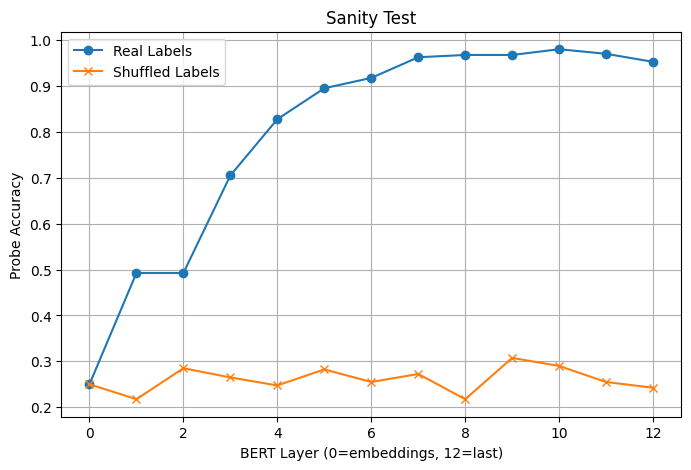

In [23]:
# ------------------------
# 5. Plot accuracy vs. layer
# ------------------------
plt.figure(figsize=(8, 5))
plt.plot(range(13), results_real, marker="o", label="Real Labels")
plt.plot(range(13), results_shuffled, marker="x", label="Shuffled Labels")
plt.xlabel("BERT Layer (0=embeddings, 12=last)")
plt.ylabel("Probe Accuracy")
plt.title("Sanity Test")
plt.legend()
plt.grid(True)
plt.show()
